In [2]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=359255009 seed_offset=0 real_seed=359255009
core.init.random: RandomGenerator:i

In [3]:
import math
import random
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from pyrosetta.rosetta.protocols.moves import *
from pyrosetta.rosetta.core.id import *

In [4]:
def within_360(ang):
    
    return ang - 360.0*int(ang/360.0)

In [5]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [6]:
def initialize_pose(seq1, seq2):
    
    n_residues = len(seq1) + len(seq2)
    
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq1, seq2)
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
    
        dof_dict.update({6*ii:TorsionID(ii+2, BB, 1), 6*ii+1:TorsionID(ii+2, BB, 2), 6*ii+2:TorsionID(ii+2, BB, 3),
                 6*ii+3:TorsionID(ii+1, BB, 5), 6*ii+4:TorsionID(ii+1, BB, 6)})
        
        if seq2 and ii == (n_residues/2) - 1:
            
            continue
        
        movemap.set(TorsionID(ii+2, BB, 1), True)
        movemap.set(TorsionID(ii+2, BB, 2), True)
        movemap.set(TorsionID(ii+2, BB, 3), True)
        movemap.set(TorsionID(ii+1, BB, 5), True)
        movemap.set(TorsionID(ii+1, BB, 6), True)
        
    for ii in range(n_residues-1):
        
        dof_dict.update({6*ii+5:TorsionID(ii+1, CHI, 1)})
        
    dof_dict.update({6*(n_residues-1):TorsionID(n_residues, CHI, 1)})
    
    movemap.set_chi(True)
        
        
        
    return pose, movemap, dof_dict

In [7]:
def find_minimum(pose, sf, movemap):
    
    
    minimum = Pose()
    minimum.assign(pose)
    #observer = AddPyMOLObserver(minimum, True)
    sf(minimum)
    n_residues = pose.total_residue()
    
    movemap = MoveMap()
    for ii in range(n_residues-1):
        
        minimum.set_alpha(  ii+2, random.uniform(0, 360))
        minimum.set_beta(   ii+2, random.uniform(0, 360))
        minimum.set_gamma(  ii+2, random.uniform(0, 360))
        minimum.set_epsilon(ii+1, random.uniform(0, 360))
        minimum.set_zeta(   ii+1, random.uniform(0, 360))
             
    for ii in range(n_residues):
        
        pose.set_chi(ii+1, random.uniform(0, 360))

    
    minmover = rosetta.protocols.minimization_packing.MinMover(movemap, sf, 'dfpmin', 1e-5, True)
    minmover.max_iter(10000)
    minmover.apply(minimum)
    
    return minimum   

In [62]:
def mode_scan(pose, dofs, dof_dict, scorefxn, mode, kT = 1.0, h = 5):
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(temp)
    
    inc = 0
    result = 0
    
    max_inc = int(60/h)
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp((E_0-scorefxn(pose))/kT)
        
        for key, val in dof_dict.iteritems():
            
            temp.set_torsion(val, dofs[key] + ind*mode[key])
            
        result += 0.5*np.exp((E_0-scorefxn(pose))/kT)
    
    # Reinitialize pose
    temp.assign(pose)
    inc = 0
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp((E_0-scorefxn(pose))/kT)
        
        for key, val in dof_dict.iteritems():
            
            temp.set_torsion(val, dofs[key] - ind*mode[key])
            
        result += 0.5*np.exp((E_0-scorefxn(pose))/kT)
        
    result *= h*np.pi/180
    print result
    return result

In [28]:
seq1 = 'ag'
seq2 = 'cu'

n_residues = len(seq1) + len(seq2)

pose, movemap, dof_dict = initialize_pose(seq1, seq2)

scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('rna/denovo/rna_hires')

In [29]:
#pose.assign(find_minimum(pose, scorefxn, movemap))
minmover = rosetta.protocols.minimization_packing.MinMover(movemap, scorefxn, 'dfpmin', 1e-5, True)
minmover.max_iter(10000)
pmm = PyMOLMover()
#pmm.apply(pose)
print dof_dict
#minmover.apply(pose)
#pmm.apply(pose)

{0: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2581aeca8>, 1: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2581ae5e0>, 2: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2581aed18>, 3: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2581aed50>, 4: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2581aed88>, 5: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd25e3aff10>, 6: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2581aedc0>, 7: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2581aedf8>, 8: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2581aee30>, 9: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2581aee68>, 10: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2581aeea0>, 11: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd25e3aff80>, 12: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2581aeed8>, 13: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2581aef10>, 14: <pyrosetta.rosetta.core.id.TorsionID object at 0x7fd2

In [30]:
import itertools

trial = Pose()
trial.assign(pose)

pose.set_alpha(2, -64)
pose.set_beta(2, 176)
pose.set_gamma(2, 53)
pose.set_epsilon(1, -150)
pose.set_zeta(1, -79)
pose.set_chi(1, 79)
pose.set_chi(2, 79)

pose.set_alpha(4, -64)
pose.set_beta(4, 176)
pose.set_gamma(4, 53)
pose.set_epsilon(3, -150)
pose.set_zeta(3, -79)
pose.set_chi(3, 79)
pose.set_chi(4, 79)

minmover.apply(pose)
#pmm.apply(pose)
h = 0.5
h_rad = h*np.pi/180
E_0 = scorefxn(pose)

dofs = []

for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
print dofs

hessian = np.zeros((len(dofs), len(dofs)))

n_pts = int(4/h + 1)
ind = int(n_pts/2)

tor_ranges = np.zeros((n_pts, len(dofs)))
energy = np.zeros((n_pts, n_pts))

for ii, dof in enumerate(dofs):
            
    tor_ranges[:, ii] = dof + np.arange(-2, 2+h, h)
    
for pair in list(itertools.combinations(range(len(dofs)), 2)):
    
    x = tor_ranges[:, pair[0]]
    y = tor_ranges[:, pair[1]]

    for ii, xx in enumerate(x):
        
        if ii in range(6*(len(seq1)-1), 6*len(seq1)) and seq2:
        
            continue
            
        pose.set_torsion(dof_dict[pair[0]], xx)
        
        for jj, yy in enumerate(y):
       
            if ii in [6,7,8,9,10,11]:
        
                continue
            
            pose.set_torsion(dof_dict[pair[1]], yy)
            
            energy[ii, jj] = scorefxn(pose)

            pose.set_torsion(dof_dict[pair[1]], dofs[pair[1]])
            
        pose.set_torsion(dof_dict[pair[0]], dofs[pair[0]])
        
    hess = numpy_hessian(energy, h)
    
    d2E_dx2 =  hess[0,0,:,:]
    d2E_dy2 =  hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[pair[0], pair[0]] == 0:
        
        hessian[pair[0], pair[0]] = d2E_dx2[5,5]
        
    if hessian[pair[1], pair[1]] == 0:
        
        hessian[pair[1], [pair[1]]] = d2E_dy2[ind, ind]
        
    hessian[pair[0],pair[1]] = d2E_dxdy[ind, ind]
    hessian[pair[1],pair[0]] = d2E_dxdy[ind, ind]
    
               
               
pmm.apply(pose)
    

[-64.60880970320548, 183.44174598401463, 49.22211111853393, -149.9447743483977, -70.43417262361827, 65.08555903699597, 0.0, 176.33, 53.07999999999999, 0.0, 0.0, 78.12921937669786, -64.13053602200296, 183.25761045052312, 48.78959412335526, -149.37478154864937, -69.5290770897737, 63.990924011544045, 77.25766203311883]


In [31]:
import scipy
import scipy.linalg

w,v = scipy.linalg.eigh(hessian)

In [32]:
print w, v
pmm.apply(pose)

[ -3.51535746e-03   8.34414994e-04   3.95595359e-03   5.45776497e-03
   9.82733568e-03   1.52609838e-02   2.14520764e-02   5.97641861e-02
   8.97088173e-02   2.68745511e-01   7.87948087e-01   1.62342052e+00
   2.16276540e+00   2.47973510e+01   2.51951892e+01   2.51951892e+01
   2.51951892e+01   2.51951892e+01   2.51958559e+01] [[ -5.86851160e-05   6.42922273e-05   7.89758487e-06  -2.03340732e-05
    2.06795317e-04   2.88384054e-04   6.27724482e-05   9.25390631e-04
    1.01369957e-03   2.74291245e-03   9.33169579e-03   2.92419719e-02
    3.00015638e-03   9.99519525e-01   0.00000000e+00  -1.52612698e-29
    0.00000000e+00   0.00000000e+00   1.82134936e-38]
 [  4.43558400e-02   1.98756484e-01  -3.73405343e-01  -4.58300002e-01
    9.58842754e-02  -1.59399439e-02   1.32128310e-01   2.45834786e-01
   -4.32765456e-02  -4.05995646e-01  -3.21638496e-01  -4.88870050e-01
    1.10669757e-01   1.78634288e-02   1.22440005e-17  -1.13618534e-17
    8.55554747e-17  -1.04479678e-16   6.61299237e-18]
 [ 

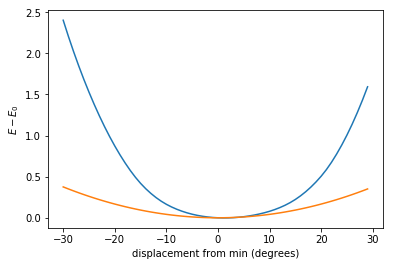

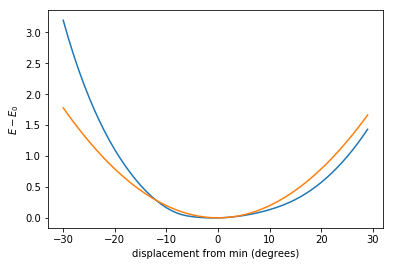

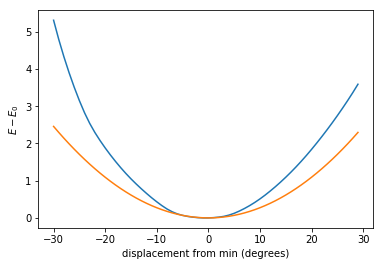

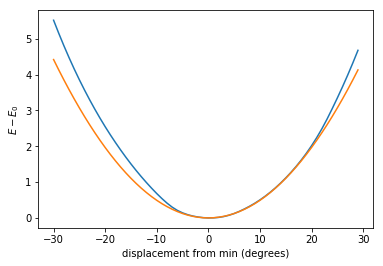

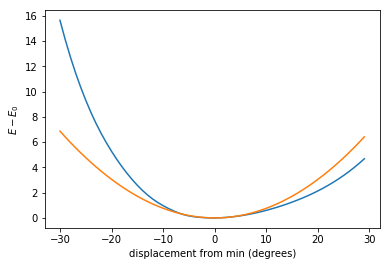

In [33]:
for kk in range(0, 6):
    
        
    K = w[kk]
    
    if K < 0: continue 
    mode = v[:,kk]
    observer = AddPyMOLObserver(pose, True)
    h = np.arange(-30,30,1)
    h_plot = h*np.pi/180.0
    #h = np.concatenate((np.append(h, 15), h[: :-1]))

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            pose.set_torsion(dof_dict[jj], dof)

        bar.append(scorefxn(pose)-E_0)
        #print E_0, scorefxn(pose)

    np.array(bar) 
    
    plt.figure()
    plt.plot(h, bar)
    plt.plot(h, 0.5*K*h**2)
    plt.xlabel('displacement from min (degrees)')
    plt.ylabel('$E-E_0$')

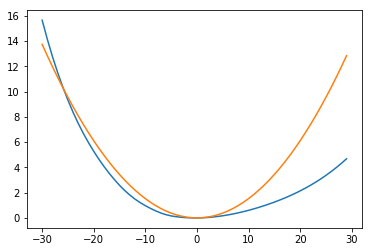

In [34]:

plt.plot(h, bar)
plt.plot(h, K*(h)**2)

In [ ]:
from scipy.special import *

Z_harmonic = 1
Z_mode = 1

for ii, kk in enumerate(w):
    
    if kk < 0: 
        
        continue 
        
    Z_harmonic *= np.sqrt(2.0*np.pi/kk)*erf(np.pi/3/np.sqrt(2.0/kk))
    Z_mode *= mode_scan(pose, dofs, dof_dict, scorefxn, v[:,ii])
    print Z_harmonic, Z_mode

In [61]:
print -np.log(Z_harmonic)*0.61633, -np.log(Z_mode)*0.61633


-2.39729034124 -15.8910923207


In [47]:
print Z_harmonic, Z_mode

48.8923710801 601249.939238
